# Video Analysis Smart Video Recorder using OpenCV

In [31]:
import os, math
import cv2  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from IPython.display import display, clear_output, Image 
import cv2, os, time 

  
plt.rcParams['figure.figsize'] = (12, 4)  
plt.rcParams['axes.grid'] = True  
  
print(cv2.__version__)

4.12.0


## 1. BASIC VIDEO FILE MANAGEMENT

• Open an MP4 file. <br>
• Display some important video parameters such as pixel resolution, frame rate,
video duration, and the number of frames. <br>


In [32]:
# open an MP4 file
video_path = "videos/videoTEST.mp4" 
 
if not os.path.exists(video_path):  
    raise FileNotFoundError(f"Video not found: {video_path}")  
  
vcap = cv2.VideoCapture(video_path)  
if not vcap.isOpened():  
    raise RuntimeError("Failed to open video. Check file path/codec support.")  
  
# display some important video parameters
width  = int(vcap.get(cv2.CAP_PROP_FRAME_WIDTH))  
height = int(vcap.get(cv2.CAP_PROP_FRAME_HEIGHT))  
fps = vcap.get(cv2.CAP_PROP_FPS) or 0.0  
nframes  = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))  # Total number of frames
duration = (nframes / fps) if fps > 0 else float('nan')  
fourcc_i = int(vcap.get(cv2.CAP_PROP_FOURCC))  # Name of the Codec
vcap.release()  
  
def fourcc_to_str(code_int):  
    # Convert numeric integer 32bits code to fourcc string  
    return "".join([chr((code_int >> (8 * i)) & 0xFF) for i in range(4)])  
  
fourcc_str = fourcc_to_str(fourcc_i)  
  
videoParams = pd.DataFrame([  
    {  
        "path": video_path,  
        "width": width,  
        "height": height,  
        "fps": round(fps, 4),  
        "frames": nframes,  
        "duration_sec": round(duration, 3) if not math.isnan(duration) else None,  
        "fourcc": fourcc_str  
    }  
])  
videoParams

,path,width,height,fps,frames,duration_sec,fourcc
0,videos/videoTEST.mp4,640,360,12.5,2613,209.04,h264


• Access different frames within the video stream. <br>


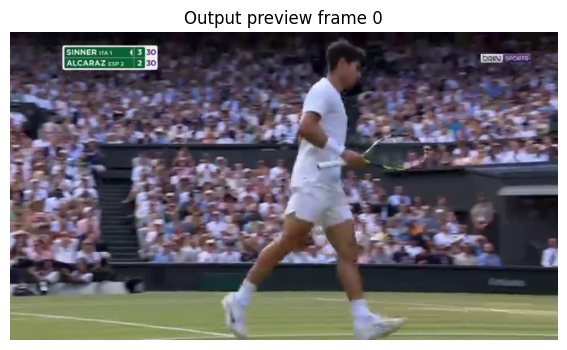

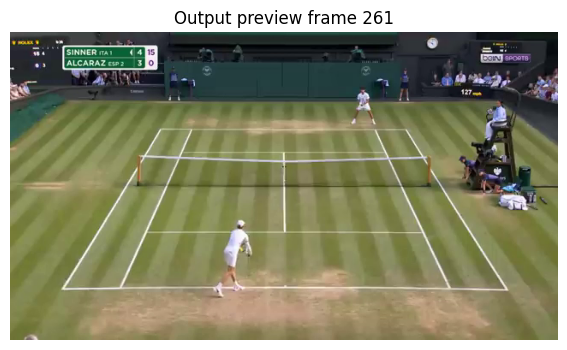

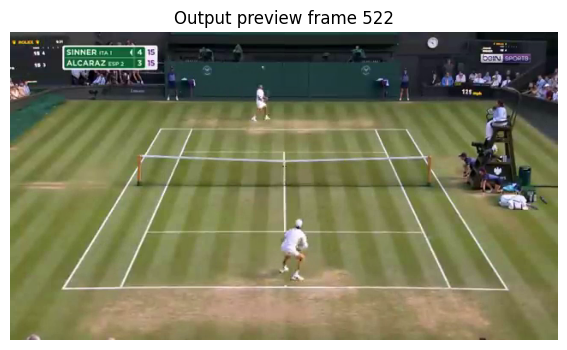

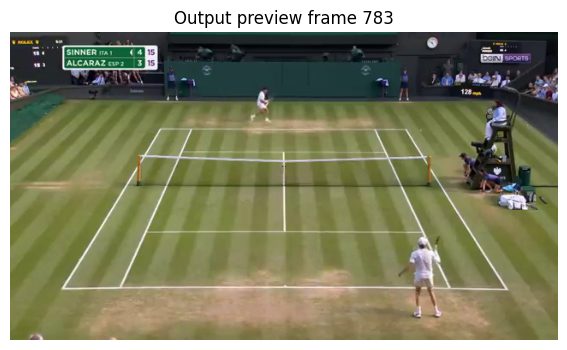

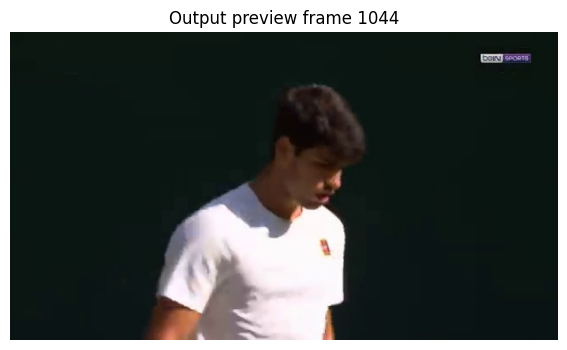

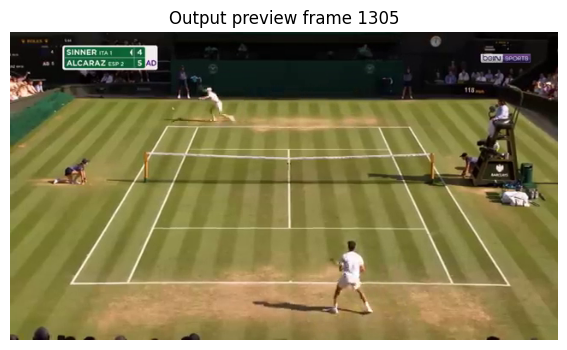

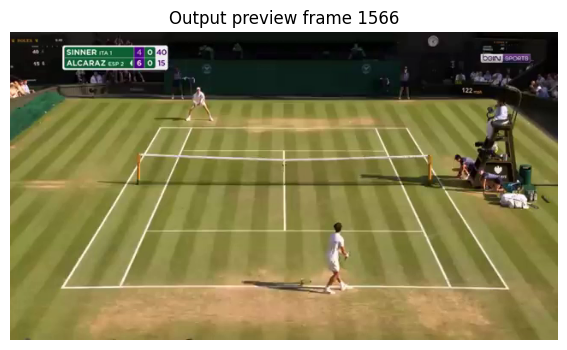

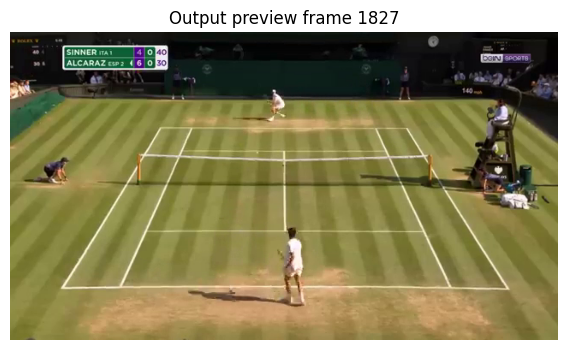

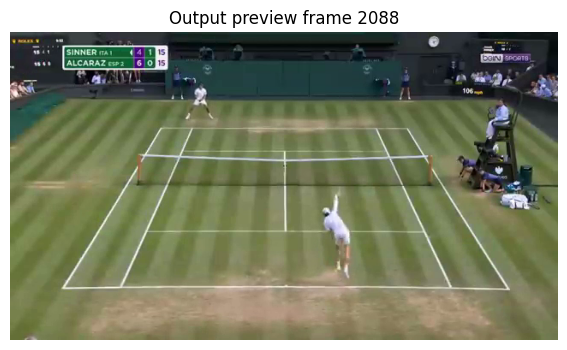

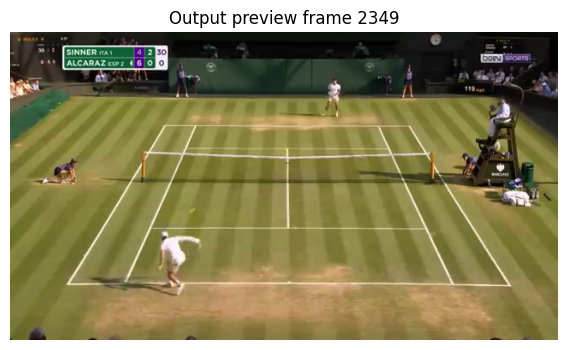

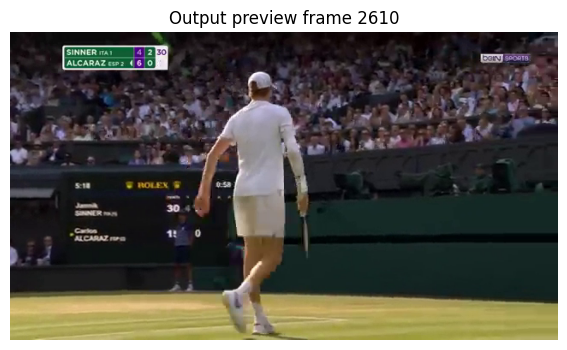

Preview complete.


In [33]:
# access different frames
frames_to_show = 10

vcap2 = cv2.VideoCapture(video_path)  
if not vcap2.isOpened():  
    raise RuntimeError("Failed to open video. Check file path/codec support.")  
  

for idx in range(0, nframes, nframes//frames_to_show):
    vcap2.set(cv2.CAP_PROP_POS_FRAMES, int(idx)) 
    ret, frame = vcap2.read()
    if not ret:
        break
    plt.title(f"Output preview frame {idx}")
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
vcap2.release()
print("Preview complete.")

• Modify pixels in the sequence’s images. Here I tried to only capture the area of the tennis court where players play, without taking into account the spectators around them.<br>
• Save the modified video stream into an MP4 file. <br>

In [34]:
output_path = "output/processed_video.mp4"

vcap3 = cv2.VideoCapture(video_path)  
if not vcap3.isOpened():  
    raise RuntimeError("Failed to open video. Check file path/codec support.")  
  
# set up writer
def try_open_writer(path, fps, size, candidates=("avc1", "H264", "X264", "mp4v")):
    W, H = size
    for four in candidates:
        fourcc = cv2.VideoWriter_fourcc(*four)
        writer = cv2.VideoWriter(path, fourcc, fps, (W, H))
        if writer.isOpened():
            print(f"Opened writer with FourCC='{four}' -> {path}")
            return writer, four
        else:
            writer.release()
    return None, None

writer, used_fourcc = try_open_writer(output_path, fps, (width, height))
if writer is None:
    vcap3.release()
    raise RuntimeError("Failed to open any MP4 writer. \nTry a different container (e.g., .avi with 'XVID') \nor install FFmpeg-backed OpenCV.")
print("Using codec:", used_fourcc, "at", fps, "FPS, size:", (width, height))


# Process - invert pixel of the tennis field
processed = 0
font = cv2.FONT_HERSHEY_SIMPLEX

try:
    while True:
        ret, frame = vcap3.read()
        if not ret:
            break  # end of stream

        txt = f"Frame {processed}"
        cv2.putText(frame, txt, (12, 32), font, 1.0, (0, 255, 0), 2, cv2.LINE_AA)
        # Set the BLUE component to zero
        #frame[height//2-150:height//2+150,width//2-100:width//2+100,0]=0 
        # Invert pixels color in a centered rectangle
        frame[height//2-160:height//2+160,width//2-250:width//2+250,:]=255-frame[height//2-160:height//2+160,width//2-250:width//2+250,:]
        
        # Write the (possibly modified) frame
        writer.write(frame)
        processed += 1
finally:
    vcap3.release()
    writer.release()

print(f"Done. Processed and wrote {processed} frames to {output_path}")
print("Output size (bytes):", os.path.getsize(output_path) if os.path.exists(output_path) else 0)

Opened writer with FourCC='avc1' -> output/processed_video.mp4
Using codec: avc1 at 12.5 FPS, size: (640, 360)
Done. Processed and wrote 2613 frames to output/processed_video.mp4
Output size (bytes): 72117526


## 2. VIDEO CUT DETECTION

• In a personal MP4 video or in one of the provided videos, perform cut detection based on the sum of absolute value pixel color components differences. Temporal and spatial subsampling can be used for optimization. <br>
• Identify cut positions in the video directly (color inversion, inserted text...) and in a saved external file, containing timestamps or frame numbers from the video.

### Metrics

In [35]:
# Read the frame number idx in the vcap video variable
def read_frame_by_index(path, idx):  
    vcap = cv2.VideoCapture(path)  
    if not vcap.isOpened():  
        return False, None  
    vcap.set(cv2.CAP_PROP_POS_FRAMES, int(idx))  
    ret, frame = vcap.read()    # ret = True if the frame is read correctly 
                                # frame = the frame in BGR format
    vcap.release()  
    return ret, frame  
  
# List of frame indices each 'step' frames throughout the video  
def indices_by_step(total_frames, step):  
    return list(range(0, max(0, total_frames), max(1, int(step))))  
  
# List of frame indices each 'step_seconds' seconds throughout the video   
def indices_by_seconds(total_frames, fps, step_seconds):  
    if fps <= 0:  
        return indices_by_step(total_frames, step=30)  
    step = int(round(step_seconds * fps))  
    return indices_by_step(total_frames, max(1, step))  

# Compute luminance stats on the 'frame_bgr' frame : mean value and std  
def luminance_stats(frame_bgr):  
    # Convert the frame 'frame_bgr' to YCrCb and take Y channel (0)  
    ycbcr = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2YCrCb)  
    Y = ycbcr[:, :, 0].astype(np.float32)  
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32)  
    return float(np.mean(Y)), float(np.std(Y)) #,np.mean(gray)), float(np.std(gray))  

# Compute de std of the values of the laplacian
def sharpness_laplacian(frame_bgr):  
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)  
    val_std = cv2.Laplacian(gray, cv2.CV_64F).std()  
    return float(val_std)  

# Compute the mean value of the absolute difference between two successive frames  
def mean_abs_diff_between_frames(frame1_bgr, frame2_bgr):
    diff_b=np.mean(np.abs(frame1_bgr[:,:,0]-frame2_bgr[:,:,0]))
    diff_g=np.mean(np.abs(frame1_bgr[:,:,1]-frame2_bgr[:,:,1]))
    diff_r=np.mean(np.abs(frame1_bgr[:,:,2]-frame2_bgr[:,:,2]))
    return diff_b + diff_g + diff_r 

Processed 2002 samples out of 2613 frames.


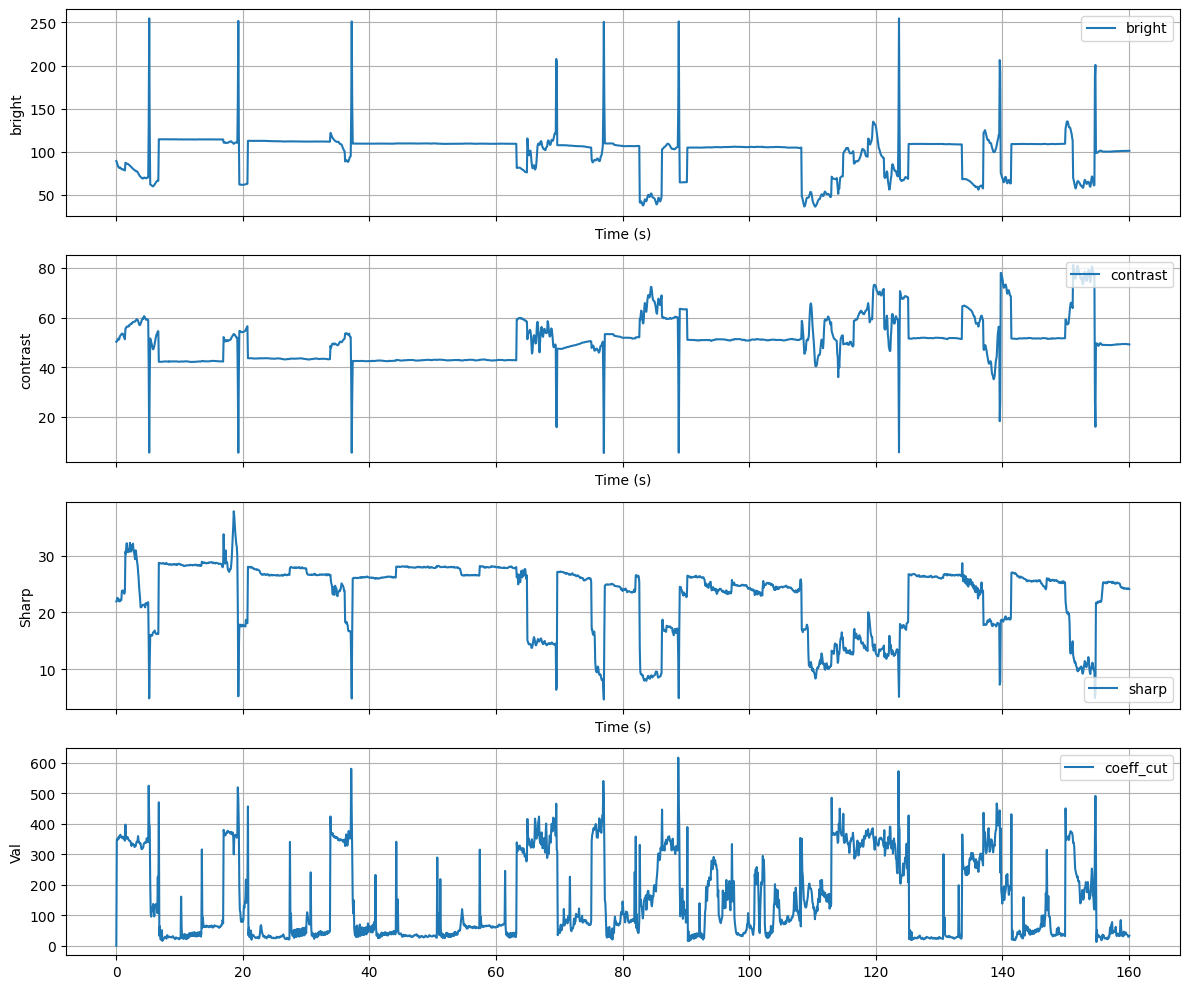

In [37]:
# cut detection  
step_between_samples = 2  # sample each 'step_between_sample'; adjust for speed/accuracy  
use_full_scan = True      # set True for computation on each frame (slower)  
  
# Open for scanning parameters  
vcap4 = cv2.VideoCapture(video_path)  
if not vcap4.isOpened():  
    raise RuntimeError("Failed to open video.")  
  

if use_full_scan or fps <= 0:  
    idxs = list(range(0, nframes, 1))  
else:  
    step = max(1, int(round(step_between_samples)))  
    idxs = list(range(0, nframes, step))  
  
times_sec = []  
frame_idx = []  

bright = []  
contrast = []  
sharp = []  
motion = []  
coeff_cut= []
  
  
vcap4.set(cv2.CAP_PROP_POS_FRAMES, 0)    
ret, prev_frame =  vcap4.read()
if not ret:  
    raise RuntimeError("Failed to read video.")   


for i in idxs:  
    vcap4.set(cv2.CAP_PROP_POS_FRAMES, i)  
    ret, frametemp = vcap4.read()  
    if not ret:  
        break  

    t = i / fps if fps > 0 else np.nan  
    frame=frametemp # Without resize
    #frame=cv2.resize(frametemp, (200,200))

    meandiff=mean_abs_diff_between_frames(prev_frame, frame)
    m, s = luminance_stats(frame)  
    vL = sharpness_laplacian(frame)  
      
        
    times_sec.append(t)  
    frame_idx.append(i)  
    coeff_cut.append(meandiff)
    bright.append(m)   
    contrast.append(s)
    sharp.append(vL)  
   
    prev_frame = frame  
         
    if i>2000:
        break
  
vcap.release()  
print(f"Processed {len(frame_idx)} samples out of {nframes} frames.")


# store results
df = pd.DataFrame({  
    'frame': frame_idx,  
    'time_sec': times_sec,   
    'bright': bright,   
    'contrast': contrast,
    'sharp': sharp,  
    'coeff_cut': coeff_cut  
})  

# plot results
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)  
axes[0].plot(df['time_sec'], df['bright'], label='bright')  
axes[0].set_xlabel('Time (s)')  
axes[0].set_ylabel('bright')  
axes[0].legend(loc='upper right')  
  
axes[1].plot(df['time_sec'], df['contrast'], label='contrast')   
axes[1].set_xlabel('Time (s)')  
axes[1].set_ylabel('contrast')  
axes[1].legend(loc='upper right')  
  
axes[2].plot(df['time_sec'], df['sharp'], label='sharp')  
axes[2].set_xlabel('Time (s)')  
axes[2].set_ylabel('Sharp')  
axes[2].legend(loc='lower right')  

axes[3].plot(df['time_sec'], df['coeff_cut'], label='coeff_cut')  
axes[3].set_ylabel('Val')  
axes[3].legend(loc='upper right')  

plt.tight_layout()  
plt.show()


### Method 1 - mean value of the absolute difference between two successive frames

In [38]:
# extraction of shot
vcap6 = cv2.VideoCapture(video_path) 

delay = 1.0 / fps if fps and fps > 0 else 1.0 / 30 
delaycut= 3.0 

meandiff = 0  
vcap6.set(cv2.CAP_PROP_POS_FRAMES, 0)  
ret, prev_frame = vcap6.read()  

threshold_cut = 230

try: 
    while True: 
        ret, frame = vcap6.read() 
        if not ret: 
            break 
        meandiff=mean_abs_diff_between_frames(prev_frame, frame)
        frame_rgb=frame
        #frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
        if meandiff>threshold_cut:
            frame_rgb[:,:,1]=0 # Set BLUE to zero
        else:
            time.sleep(delay) 
         
        _, data = cv2.imencode('.jpg', frame_rgb, [int(cv2.IMWRITE_JPEG_QUALITY), 80]) 
        clear_output(wait=True) 
        display(Image(data=data.tobytes())) 
        #if meandiff>threshold_cut:
        #    time.sleep(delaycut) 
        
        prev_frame=frame
        
finally: 
    vcap6.release() 
    clear_output(wait=True) 
    print("Inline playback finished.")
    
    
vcap6.release()  

out_csv = os.path.splitext(os.path.basename(video_path))[0] + "_analysis.csv"  
df.to_csv(out_csv, index=False)  # index=True to Write row names
print(f"Saved: {out_csv}")


Inline playback finished.
Saved: videoTEST_analysis.csv


This method works well, but sometimes a cut is detected during the effective palytime.

### Method 2 - Histogram Difference

In [39]:
def process_video_cuts(video_path, threshold=0.45, output_name="output/final_cuts_analysis.mp4"):
    
    vcap7 = cv2.VideoCapture(video_path)
    
    # Video properties
    fps = vcap7.get(cv2.CAP_PROP_FPS)
    width = int(vcap7.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vcap7.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(vcap7.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # 'avc1' codec for H.264 (Universal compatibility)
    fourcc = cv2.VideoWriter_fourcc(*'avc1') 
    out = cv2.VideoWriter(output_name, fourcc, fps, (width, height))
    
    # Fallback: if avc1 is not supported on your system, try 'XVID'
    if not out.isOpened():
        print("Codec 'avc1' failed. Falling back to 'mp4v'...")
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_name, fourcc, fps, (width, height))
    
    prev_hist = None
    cut_logs = []
    frame_count = 0

    print(f"Processing started. Exporting to: {output_name}")

    try:
        while True:
            ret, frame = vcap7.read()
            if not ret:
                break

            frame_count += 1
            timestamp = frame_count / fps if fps > 0 else 0
            
            # 1. Histogram Analysis
            hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
            hist = cv2.calcHist([hsv], [0], None, [32], [0, 180])
            cv2.normalize(hist, hist)

            is_cut = False
            score = 0
            
            if prev_hist is not None:
                diff = cv2.compareHist(prev_hist, hist, cv2.HISTCMP_CORREL)
                score = 1.0 - diff
                
                if score > threshold:
                    is_cut = True
                    cut_logs.append({
                        'frame': frame_count,
                        'timestamp_sec': round(timestamp, 3),
                        'diff_score': round(score, 4)
                    })

            # 2. Frame Decoration
            processed_frame = frame.copy()
            
            if is_cut:
                # Add visual alert
                cv2.rectangle(processed_frame, (0, 0), (width, height), (0, 0, 255), 20)
                cv2.putText(processed_frame, "!!! CUT DETECTED !!!", (50, 150), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
                
                # Repeat frame for 1 second in the output video
                for _ in range(int(fps)):
                    out.write(processed_frame)
            else:
                # Standard HUD info
                status_text = f"Frame: {frame_count} | Diff: {score:.3f}"
                cv2.putText(processed_frame, status_text, (20, height - 30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                out.write(processed_frame)

            prev_hist = hist
            
            if frame_count % 100 == 0:
                print(f"Progress: {int((frame_count/total_frames)*100)}% ({frame_count}/{total_frames})", end="\r")
            
    finally:
        vcap7.release()
        out.release()
        print(f"\nProcessing complete. Saved to {output_name}")
        
    return cut_logs



results = process_video_cuts(video_path, threshold=0.45)
if results:
    pd.DataFrame(results).to_csv("cut_detection_results.csv", index=False)

Processing started. Exporting to: output/final_cuts_analysis.mp4
Progress: 99% (2600/2613)
Processing complete. Saved to output/final_cuts_analysis.mp4


## 3. SHOT IDENTIFICATION

Since the video test is from a match at Wimbledon, we will try to capture whether or not there is green in the video,  given that it is a tournament played on grass. We can tell if the video is on the field camera shot when, for example, 10% of the image contains green.

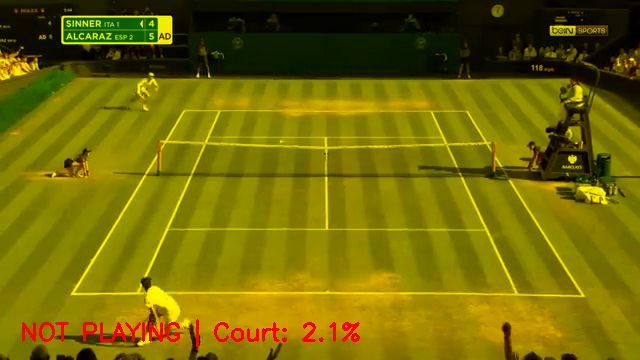

In [ ]:
# --- Settings ---
# Green court boundaries (HSV)
lower_green = np.array([35, 40, 40], dtype="uint8") 
upper_green = np.array([85, 255, 255], dtype="uint8")
threshold_ratio = 0.10 # 40% threshold

vcap6 = cv2.VideoCapture(video_path) 
vcap6.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, prev_frame = vcap6.read()

# Setup delay for normal playback
fps = vcap6.get(cv2.CAP_PROP_FPS)
delay = 1.0 / fps if fps and fps > 0 else 1.0 / 30

analysis_data = []
frame_count = 0

try: 
    while True: 
        ret, frame = vcap6.read() 
        if not ret: 
            break 
        
        frame_count += 1
        current_timestamp = frame_count / fps if fps > 0 else 0

        # 1. Analyze Court Presence (Spatial Analysis)
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, lower_green, upper_green)
        court_ratio = cv2.countNonZero(mask) / (frame.shape[0] * frame.shape[1])
        
        frame_display = frame.copy()
        
        # 2. Logic: Speed & Color based on 40% threshold
        if court_ratio > threshold_ratio:
            status = "PLAYING"
            # NORMAL SPEED
            time.sleep(delay) 
        else:
            status = "NOT PLAYING"
            # ACCELERATED: No time.sleep()
            # VISUAL FEEDBACK: Set Blue channel to 0 (BGR index 0)
            frame_display[:, :, 0] = 0 
        
        # 3. Real-time Visualization (HUD)
        text = f"{status} | Court: {court_ratio:.1%}"
        color = (0, 255, 0) if status == "PLAYING" else (0, 0, 255)
        cv2.putText(frame_display, text, (20, height - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

        # 4. Display to Notebook
        _, data = cv2.imencode('.jpg', frame_display, [int(cv2.IMWRITE_JPEG_QUALITY), 80]) 
        clear_output(wait=True) 
        display(Image(data=data.tobytes())) 
        
        # Log results for CSV
        # 5. Log Data with Timestamps
        analysis_data.append({
            'frame': frame_count,
            'timestamp_sec': round(current_timestamp, 3),
            'court_ratio': round(court_ratio, 4),
            'status': status
        })
        prev_frame = frame
        
finally: 
    vcap6.release() 
    clear_output(wait=True) 
    print("Inline playback finished.")

# Save results
import pandas as pd
df = pd.DataFrame(analysis_data)
out_csv = os.path.splitext(os.path.basename(video_path))[0] + "_tennis_logic.csv"
df.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")

Extracting the game by detecting the color green works well when the ratio of green in the image is greater than 10%, except in very sunny weather. Glare on the court discolors the image, making the green too dull to be captured by the current threshold.